### Step 1: Install the Required Libraries

In [1]:
!pip install transformers datasets torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

This command installs three essential libraries:

- **transformers:** Used for working with the CLIP model.
- **datasets:** Provides easy access to various datasets, including the one used here.
- **torch:** The core library for building and training neural networks.

### Step 2: Import Necessary Libraries

In [46]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel, AdamW
from datasets import load_dataset
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau


**This block imports all the necessary libraries and modules:**

- **torch and torch.nn**: Fundamental components for building and training neural networks.
- **DataLoader**: Utility from torch.utils.data to load data in batches.
- **CLIPProcessor and CLIPModel**: Key components from transformers to process inputs and initialize the CLIP model.
- **AdamW**: An optimizer designed for training deep learning models with weight decay.
- **load_dataset**: Function from the datasets library used to load the specified dataset.
- **transforms from torchvision**: Tools for applying data augmentation techniques to images.
- **tqdm**: Utility for displaying progress bars during training loops.
- **ReduceLROnPlateau**: A learning rate scheduler that reduces the learning rate when the performance metric has stopped improving.

### Step 3: Check for GPU Availability

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


This step checks whether a GPU is available for training. If a GPU is detected, the model and data will be processed on it, otherwise, the CPU will be used. This is crucial as using a GPU can significantly speed up the training process.



### Step 4: Load the Dataset

In [48]:
dataset = load_dataset('zmao/food_img_caption_small')


The dataset zmao/food_img_caption_small is loaded using the load_dataset function from the datasets library. This dataset contains pairs of images and corresponding text captions. It's specifically designed for tasks like image-to-text and text-to-image feature mapping, making it ideal for training a CLIP model.

### Step 5: Define Data Augmentation Pipeline

In [49]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
from torchvision.transforms import functional as F

data_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
])


**This step sets up a series of image transformations (data augmentation) to enhance the diversity of the training data:**

- **RandomResizedCrop(224):** Randomly crops the image to a size of 224x224 pixels.
- **RandomHorizontalFlip():** Randomly flips the image horizontally.
- **ColorJitter:** Randomly changes the brightness, contrast, saturation, and hue of the image.

These transformations help improve the model's generalization by introducing variations in the training data.

### Step 6: Define Custom Collate Function

In [50]:
def collate_fn(batch):
    augmented_images = [data_augmentation(item['image']) for item in batch]
    texts = [item['text'] for item in batch]
    inputs = processor(text=texts, images=augmented_images, return_tensors="pt", padding=True)
    return inputs


The collate function processes a batch of data at once. It:

- Applies the data augmentation pipeline to each image in the batch.
- Collects the corresponding text captions.
- Uses the CLIP processor to convert the images and texts into tensors, making them ready for input into the model.

### Step 7: Split the Dataset into Training and Validation Sets

In [51]:
if 'test' not in dataset:
    dataset = dataset['train'].train_test_split(test_size=0.2)


This step checks if a separate test (or validation) split is present in the dataset. If not, it manually creates one by splitting the training set into 80% training and 20% validation data. This is important to evaluate the model's performance on unseen data during training.

### Step 8: Create DataLoaders

In [52]:
train_loader = DataLoader(dataset['train'], batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset['test'], batch_size=16, shuffle=False, collate_fn=collate_fn)


Here, the DataLoader objects are created for both the training and validation sets:
**bold text**
- **train_loader:** Loads the training data in batches of 16, shuffles the data to ensure randomness.
- **val_loader:** Loads the validation data in batches of 16 without shuffling, preserving the order.

The collate_fn defined earlier is used to preprocess the data during loading.

### Step 9: Load the Pre-trained CLIP Model

In [53]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

The CLIP model (clip-vit-base-patch32) is loaded with pre-trained weights. The model is then moved to the GPU (if available) for faster training and inference. This model is capable of processing both images and text to learn their shared representations.



### Step 10: Set Up the Optimizer and Scheduler

In [54]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


The optimizer and learning rate scheduler are set up:

- **AdamW:** An optimizer with weight decay to prevent overfitting.
- **ReduceLROnPlateau:** Reduces the learning rate if the validation loss stops improving, helping the model to converge better.

### Step 11: Define Custom Contrastive Loss Function

In [55]:
import torch
import torch.nn.functional as F # Import torch.nn.functional and alias it as F

def contrastive_loss(logits_per_image, logits_per_text):
    labels = torch.arange(logits_per_image.size(0), device=logits_per_image.device)
    image_loss = F.cross_entropy(logits_per_image, labels) # Now F refers to the correct module
    text_loss = F.cross_entropy(logits_per_text, labels)
    return (image_loss + text_loss) / 2

A custom loss function is defined, which computes the contrastive loss between image and text logits:

- It creates labels corresponding to each image-text pair.
- cross_entropy: Calculates the loss for both image and text logits.
- The final loss is the average of the image and text losses.


### Step 12: Training and Validation Loop

100%|██████████| 11/11 [00:01<00:00,  5.75it/s]


Epoch 1: Avg Train Loss: 1.4090, Avg Val Loss: 1.2897


100%|██████████| 11/11 [00:02<00:00,  4.06it/s]


Epoch 2: Avg Train Loss: 0.9308, Avg Val Loss: 1.1053


100%|██████████| 11/11 [00:01<00:00,  5.82it/s]


Epoch 3: Avg Train Loss: 0.7266, Avg Val Loss: 1.1424


100%|██████████| 11/11 [00:01<00:00,  5.62it/s]


Epoch 4: Avg Train Loss: 0.6020, Avg Val Loss: 1.2710


100%|██████████| 11/11 [00:02<00:00,  4.51it/s]


Epoch 5: Avg Train Loss: 0.5322, Avg Val Loss: 1.3381


100%|██████████| 11/11 [00:01<00:00,  5.74it/s]


Epoch 6: Avg Train Loss: 0.4141, Avg Val Loss: 1.2968


100%|██████████| 11/11 [00:01<00:00,  5.86it/s]


Epoch 7: Avg Train Loss: 0.3316, Avg Val Loss: 1.4967


100%|██████████| 11/11 [00:02<00:00,  4.28it/s]


Epoch 8: Avg Train Loss: 0.3432, Avg Val Loss: 1.4191


100%|██████████| 11/11 [00:01<00:00,  5.67it/s]


Epoch 9: Avg Train Loss: 0.3067, Avg Val Loss: 1.5445


100%|██████████| 11/11 [00:01<00:00,  5.88it/s]


Epoch 10: Avg Train Loss: 0.3425, Avg Val Loss: 1.4051


100%|██████████| 11/11 [00:02<00:00,  5.01it/s]


Epoch 11: Avg Train Loss: 0.2801, Avg Val Loss: 1.2222


100%|██████████| 11/11 [00:01<00:00,  5.78it/s]


Early stopping triggered at epoch 12
Training complete.


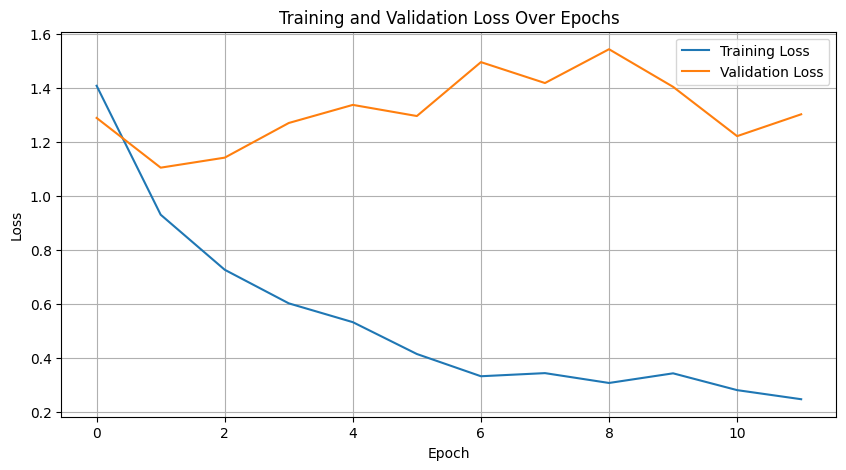

In [56]:
import matplotlib.pyplot as plt

early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
max_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)


train_losses = []
val_losses = []

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values)
        loss = contrastive_loss(outputs.logits_per_image, outputs.logits_per_text)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            pixel_values = batch['pixel_values'].to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values)
            loss = contrastive_loss(outputs.logits_per_image, outputs.logits_per_text)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    print(f"Epoch {epoch + 1}: Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

print("Training complete.")

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


**This is the main training loop that runs for a maximum of 20 epochs:**

1. The model is set to training mode, and the training loss is initialized.
2. For each batch of data:
* The optimizer gradients are zeroed out.
* Input images and text captions are processed, and the loss is calculated using the custom contrastive loss function.
* The optimizer updates the model parameters based on the gradients.
* The average training loss is computed across all batches.
3. During validation:

- The model is set to evaluation mode, and no gradients are computed.
- The validation loss is calculated for each batch and averaged across all batches.
- The learning rate is adjusted based on the average validation loss.
4. If the validation loss improves, the model's state is saved; otherwise, the counter for early stopping is incremented.
5. If the model does not improve for a specified number of epochs (early_stopping_patience), the training loop breaks early.